In [ ]:
# Install required libraries
% pip install pandas numpy scikit-learn matplotlib xgboost lightgbm scipy


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Phishing URL Detection with Machine Learning
In this notebook, we will:
1. Load and preprocess data.
2. Extract manual features from URLs.
3. Tokenize URLs using TF-IDF vectorization.
4. Combine manual and tokenized features.
5. Train and evaluate multiple machine learning models.
6. Analyze feature importance.
7. Perform hyperparameter tuning on the Random Forest model.

In [2]:
import re
import pandas as pd
from collections import Counter
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

### URL Feature Extraction

This cell defines a function `extract_features` that extracts various manual features from a given URL. These features are useful for detecting phishing or malicious URLs.

1. **Suspicious Keywords and Patterns**  
   - **Suspicious Words**: Checks for words like `login`, `verify`, `secure`, etc., often found in phishing URLs.  
   - **URL Shorteners**: Identifies shortened URLs (e.g., `bit.ly`, `tinyurl.com`).  
   - **Suspicious TLDs**: Flags domains with top-level domains (TLDs) like `.tk`, `.ml`, and `.info` commonly used by phishing sites.  

2. **Shannon Entropy**  
   - Measures the randomness or complexity of a URL. Higher entropy indicates more randomness, which is common in phishing URLs.

3. **Extracted Features**  
   - **Basic Features**:  
     - URL length, number of digits, special characters, subdomains, etc.  
   - **Domain-Specific Features**:  
     - TLD check, presence of IP addresses, hyphens, and `@` symbols in the URL.  
   - **Additional Features**:  
     - Repeated characters, presence of encoded URLs, uppercase characters, and non-ASCII characters.

These extracted features help in building machine learning models for URL classification by identifying patterns commonly associated with malicious URLs.


In [3]:
import re
import math
from collections import Counter

# Define suspicious words, URL shorteners, and suspicious TLDs
SUSPICIOUS_WORDS = ['login', 'signin', 'bank', 'update', 'verify', 'secure', 'account', 'password', 'confirm', 'free']
URL_SHORTENERS = ['bit.ly', 'tinyurl.com', 'goo.gl', 'is.gd', 't.co']
SUSPICIOUS_TLDS = ['.tk', '.ml', '.cf', '.info', '.xyz', '.top']

def calculate_entropy(url):
    """Calculate Shannon entropy of a URL."""
    p, lns = Counter(url), float(len(url))
    return -sum(count / lns * math.log2(count / lns) for count in p.values())

def extract_features(url):
    """Extract manual features from a URL."""
    # Extract domain using regex (includes subdomains)
    match = re.search(r'^(?:https?:\/\/)?(?:www\.)?([^\/]+)', url)
    domain = match.group(1) if match else ''
    
    # Extract the TLD
    tld_match = re.search(r'\.([a-z]{2,})$', domain)
    tld = tld_match.group(0) if tld_match else ''

    return {
        # Basic features
        'url_length': len(url),
        'num_digits': len(re.findall(r'\d', url)),
        'num_special_chars': len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', url)),
        'num_subdomains': domain.count('.') - 1,
        'contains_https': int('https' in url),
        'contains_ip': int(bool(re.match(r'^(?:\d{1,3}\.){3}\d{1,3}', domain))),
        'has_suspicious_words': int(any(word in url.lower() for word in SUSPICIOUS_WORDS)),
        'is_shortened_url': int(any(shortener in url for shortener in URL_SHORTENERS)),
        'url_entropy': calculate_entropy(url),
        'num_params': url.count('&') + url.count('?'),
        '0s_in_url': url.count('0'),
        'domain_length': len(domain),
        
        # Additional features
        'contains_suspicious_tld': int(tld in SUSPICIOUS_TLDS),
        'has_hyphens': int('-' in domain),
        'repeated_chars': max(Counter(url).values()),
        'encoded_url': int('%' in url),
        'at_symbol_in_url': int('@' in url),
        # 'hexadecimal_in_url': int(bool(re.search(r'%[0-9a-fA-F]{2}', url))),   # high correlation with encoded_url
        'num_uppercase_chars': len(re.findall(r'[A-Z]', url)),
        'non_ascii_chars': len(re.findall(r'[^\x00-\x7F]', url)),
        # 'length_path_and_query': len(re.sub(r'^[^/]*://[^/]+', '', url))       # high correlation with url_length
    }


## Load Dataset
We will load the dataset and preprocess it by extracting manual features.


In [4]:
file_path = './data/phishing_site_urls.csv'  # Update path as needed
df = pd.read_csv(file_path)
sampled_df = df.sample(frac=0.6, random_state=42)

# Extract manual features
sampled_df = pd.DataFrame(df['URL'].apply(lambda x: extract_features(x)).tolist())
sampled_df['Label'] = df['Label'].map({'good': 0, 'bad': 1})  # Encode labels

# Drop rows with missing values
sampled_df.dropna(inplace=True)

# Align original dataset with filtered rows
df_aligned = df.loc[sampled_df.index]

print("Data Loaded and Features Extracted")
print(sampled_df.shape)
sampled_df.head()

Data Loaded and Features Extracted
(549345, 20)


,url_length,num_digits,num_special_chars,num_subdomains,contains_https,contains_ip,has_suspicious_words,is_shortened_url,url_entropy,num_params,0s_in_url,domain_length,contains_suspicious_tld,has_hyphens,repeated_chars,encoded_url,at_symbol_in_url,num_uppercase_chars,non_ascii_chars,Label
0,225,58,10,0,0,0,1,0,5.026886,4,8,9,0,0,13,0,0,2,0,1.0
1,81,1,6,0,0,0,0,0,4.686883,1,0,11,0,0,7,0,0,0,0,1.0
2,177,47,7,0,0,0,1,0,4.721044,0,0,16,0,0,16,0,0,0,0,1.0
3,60,0,6,1,0,0,0,0,4.079842,0,0,18,0,0,6,0,0,0,0,1.0
4,116,21,2,0,0,0,0,0,4.608653,1,0,19,0,0,13,0,0,12,0,1.0


### Correlation Matrix of Manual Features

In this cell, we calculate and visualize the correlation matrix for the manual features extracted from the dataset. The correlation matrix helps identify the relationships between different features, highlighting which features are strongly positively or negatively correlated. 



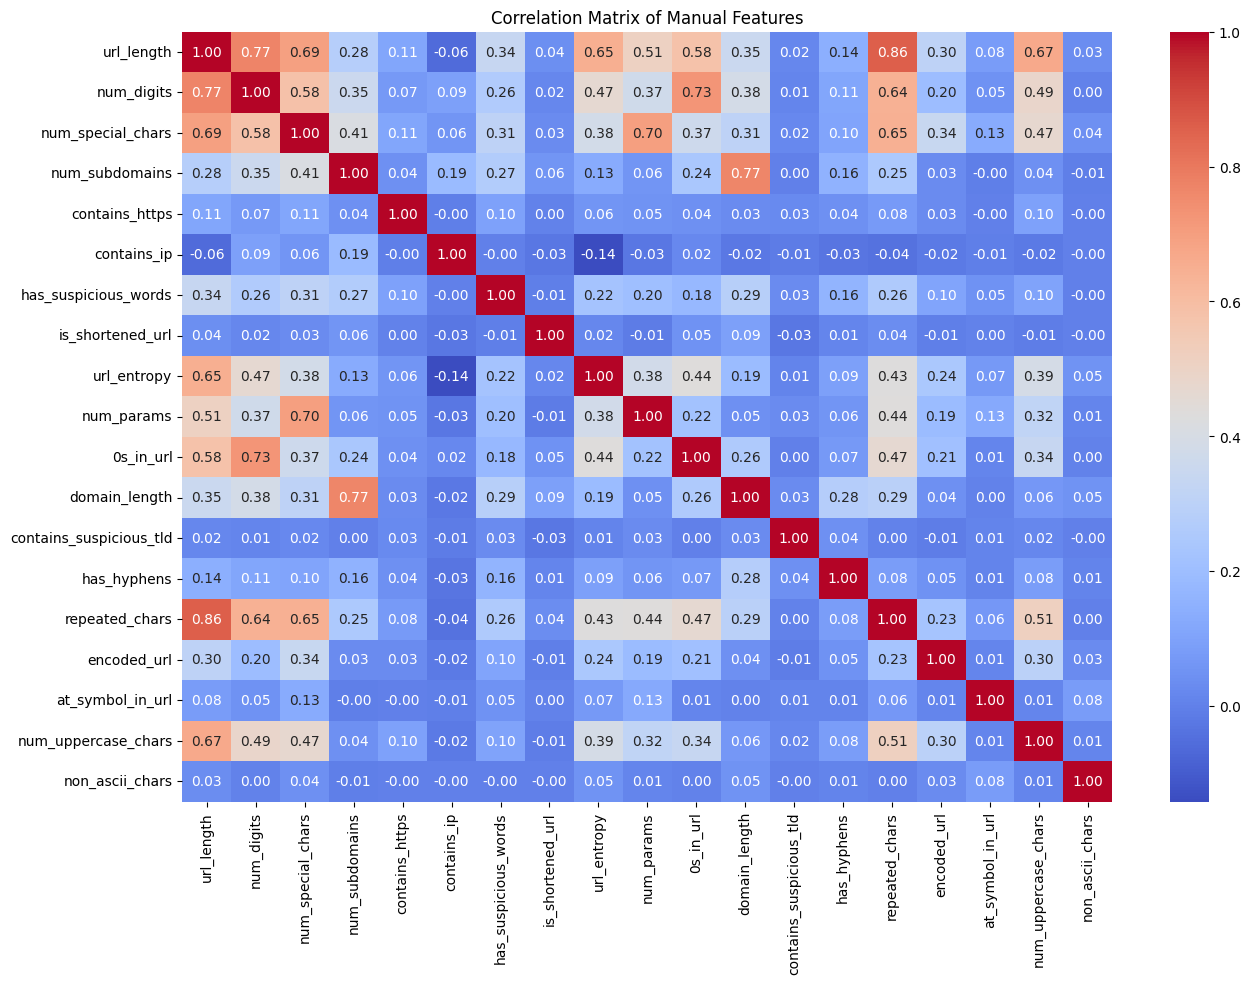

In [5]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = sampled_df.drop(columns=['Label']).corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Manual Features')
plt.show()


## Tokenize URLs using TF-IDF
We tokenize the URLs to capture character-level n-grams.


In [6]:
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=200)
tfidf_features = tfidf_vectorizer.fit_transform(df_aligned['URL'])  # Tokenized features

print("TF-IDF Tokenization Complete")
tfidf_features

TF-IDF Tokenization Complete


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7969653 stored elements and shape (549345, 200)>



## Combine Manual and Tokenized Features
We combine the manual features with the TF-IDF features for model training.


In [7]:
X_manual = sampled_df.drop(columns=['Label'])
X_combined = hstack([X_manual.values, tfidf_features])
y = sampled_df['Label']


## Split Data into Training and Testing Sets
Split the combined features and labels into training and testing datasets.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train-Test Split Complete: Train Size = {X_train.shape}, Test Size = {X_test.shape}")

Train-Test Split Complete: Train Size = (384541, 219), Test Size = (164804, 219)


## Class Distribution
Check the distribution of classes in the dataset. This helps to understand the balance between the 'good' and 'bad' URLs.



Class Distribution:
Label
0.0    392924
1.0    156421
Name: count, dtype: int64


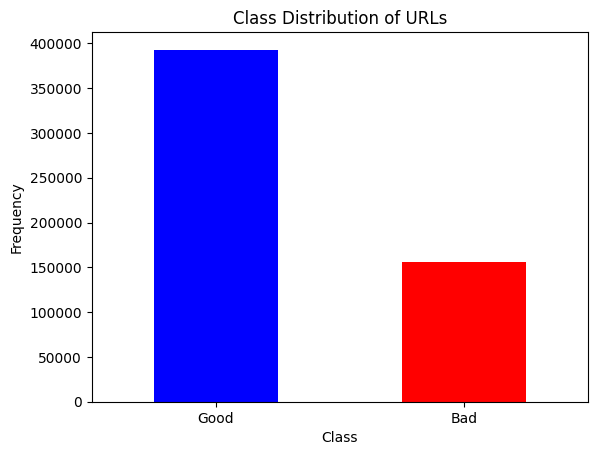

In [9]:
class_distribution = sampled_df['Label'].value_counts()
print("Class Distribution:")
print(class_distribution)
class_distribution.plot(kind='bar', color=['blue', 'red'])
plt.title('Class Distribution of URLs')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Good', 'Bad'], rotation=0)
plt.show()

## Addressing Class Imbalance with SMOTE
We observe a class imbalance in our dataset. To address this, we will use the Synthetic Minority Over-sampling Technique (SMOTE) to balance the classes in the training set.

In [10]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled Training Set Shape: {X_train_resampled.shape}, {y_train_resampled.shape}")

Resampled Training Set Shape: (550092, 219), (550092,)


Resampled Class Distribution:
Label
0.0    275046
1.0    275046
Name: count, dtype: int64


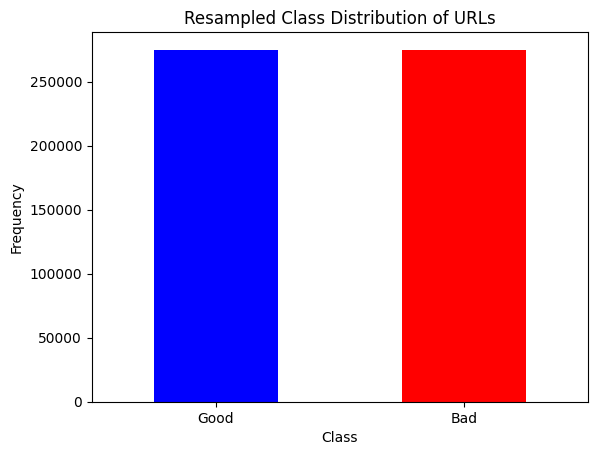

In [11]:
# Visualize the class distribution after applying SMOTE
resampled_class_distribution = y_train_resampled.value_counts()
print("Resampled Class Distribution:")
print(resampled_class_distribution)
resampled_class_distribution.plot(kind='bar', color=['blue', 'red'])
plt.title('Resampled Class Distribution of URLs')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Good', 'Bad'], rotation=0)
plt.show()

### Model Selection for Classification

We define a set of machine learning models to evaluate their performance on phishing URL detection:

- **Logistic Regression**: A linear probabilistic model.  
- **Decision Tree**: A non-linear, interpretable tree-based model.  
- **Random Forest**: An ensemble of decision trees to reduce overfitting.  
- **XGBoost**: A scalable gradient boosting model with log loss as the evaluation metric.  
- **LightGBM**: A fast gradient boosting model optimized for large datasets.

These models will be trained and evaluated for their accuracy in phishing URL classification.


In [12]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

print("Training Complete")

Training Logistic Regression...
Accuracy: 0.8186
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88    117878
         1.0       0.78      0.50      0.61     46926

    accuracy                           0.82    164804
   macro avg       0.81      0.72      0.75    164804
weighted avg       0.81      0.82      0.80    164804

--------------------------------------------------
Training Decision Tree...
Accuracy: 0.9296
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95    117878
         1.0       0.87      0.89      0.88     46926

    accuracy                           0.93    164804
   macro avg       0.91      0.92      0.91    164804
weighted avg       0.93      0.93      0.93    164804

--------------------------------------------------
Training Random Forest...
Accuracy: 0.9556
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    117878


### Model Performance Comparison

This cell displays the accuracy of each model and visualizes the results using a horizontal bar chart. It helps identify the best-performing model based on accuracy.


Model Comparison:
Logistic Regression: 0.8186
Decision Tree: 0.9296
Random Forest: 0.9556
XGBoost: 0.9321
LightGBM: 0.9216


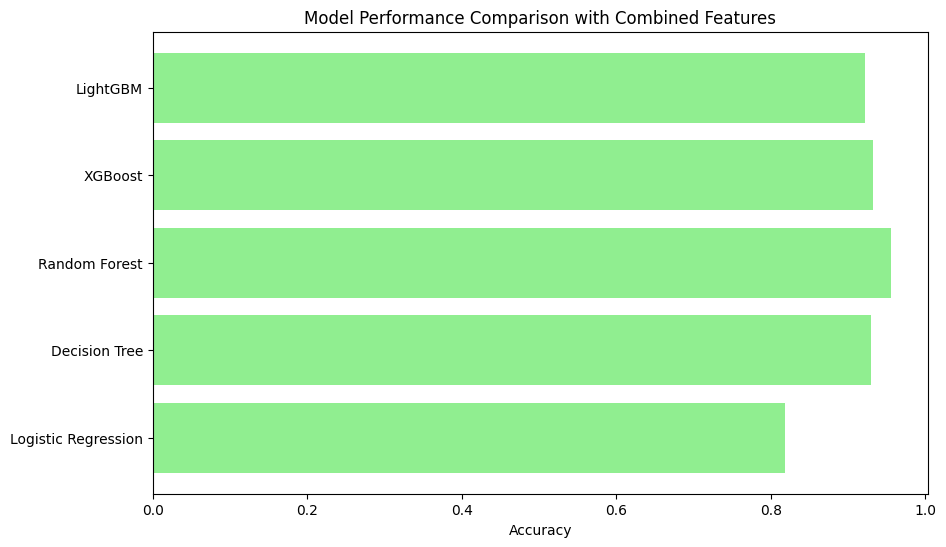

In [13]:
print("Model Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='lightgreen')
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison with Combined Features')
plt.show()

### Feature Importance Visualization

This cell displays and visualizes the most important features for tree-based models (Random Forest, XGBoost, and LightGBM):

1. **Feature Name Combination**  
   - Combines manual feature names and TF-IDF feature names into a single list for interpretation.

2. **Feature Importance Calculation**  
   - Extracts feature importances from the models:  
     - `Random Forest`  
     - `XGBoost`  
     - `LightGBM`  

3. **Top Features Display**  
   - Prints the top `n` features (default 20) sorted by importance.  
   - Generates a horizontal bar chart to visualize the feature contributions for each model.

This analysis helps identify which features contribute most to the model's decision-making process.



Top 20 Features for Random Forest:

num_digits: 0.0592
url_entropy: 0.0418
domain_length: 0.0405
url_length: 0.0403
TFIDF_.com/: 0.0287
TFIDF_com/: 0.0286
TFIDF_om/: 0.0268
has_suspicious_words: 0.0240
TFIDF_.php: 0.0226
num_special_chars: 0.0212
TFIDF_.com: 0.0204
TFIDF_.co: 0.0195
TFIDF_com: 0.0177
TFIDF_php: 0.0174
repeated_chars: 0.0158
TFIDF_.ph: 0.0153
TFIDF_ogin: 0.0153
num_uppercase_chars: 0.0129
num_subdomains: 0.0128
TFIDF_gin: 0.0119


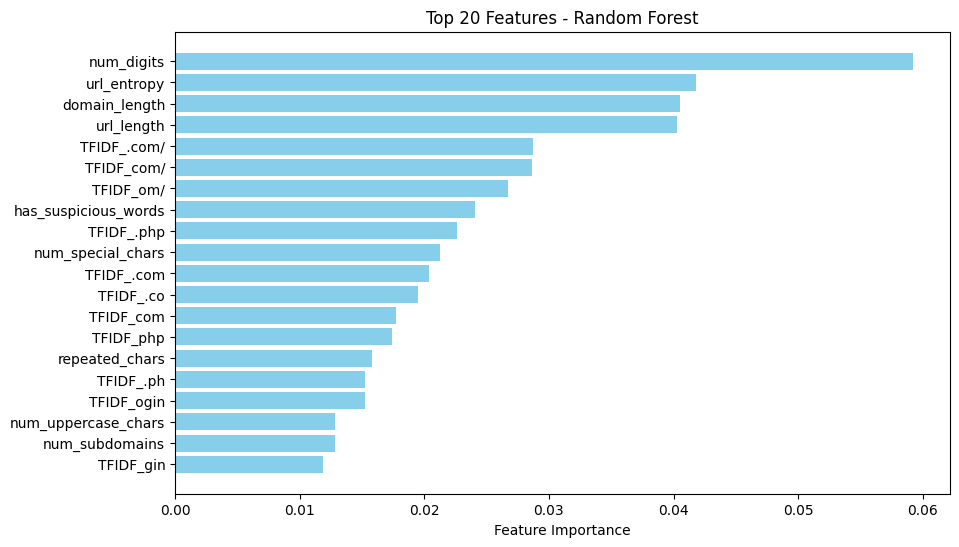


Top 20 Features for XGBoost:

TFIDF_rg/: 0.2873
has_suspicious_words: 0.0584
TFIDF_org: 0.0468
TFIDF_php?: 0.0340
TFIDF_ogin: 0.0321
TFIDF_php: 0.0289
TFIDF_.com/: 0.0215
contains_ip: 0.0169
TFIDF_wiki: 0.0121
TFIDF_hp?: 0.0114
TFIDF_gin: 0.0111
TFIDF_com/w: 0.0106
TFIDF_.php: 0.0101
TFIDF_.asp: 0.0094
TFIDF_/20: 0.0085
TFIDF_om.: 0.0082
contains_suspicious_tld: 0.0082
TFIDF_amp;: 0.0079
TFIDF_htm: 0.0075
TFIDF_y.com: 0.0075


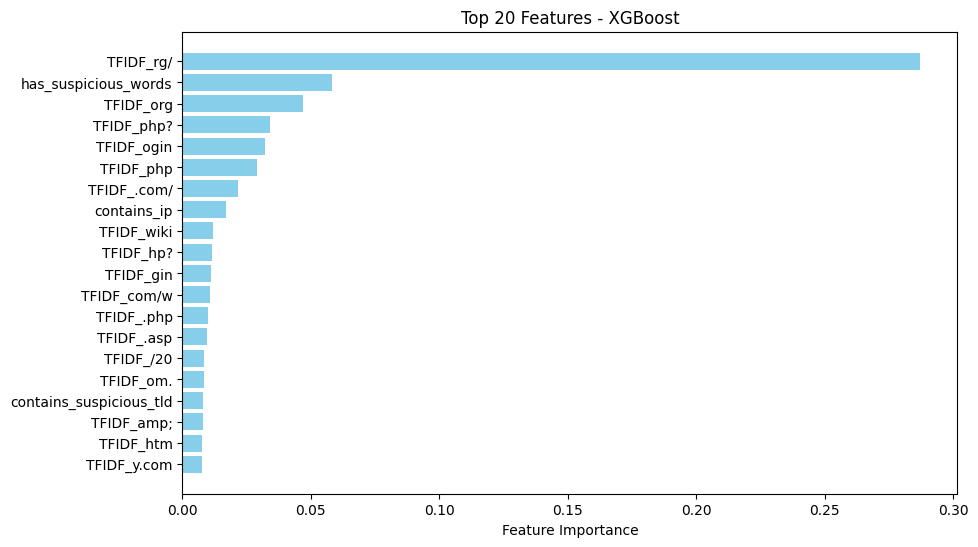


Top 20 Features for LightGBM:

url_length: 202.0000
domain_length: 195.0000
num_digits: 187.0000
num_special_chars: 96.0000
url_entropy: 88.0000
num_subdomains: 86.0000
TFIDF_htm: 58.0000
TFIDF_www: 51.0000
num_uppercase_chars: 49.0000
TFIDF_es/: 44.0000
TFIDF_.com/: 42.0000
num_params: 42.0000
TFIDF_.co: 38.0000
TFIDF_/in: 35.0000
contains_ip: 33.0000
TFIDF_.com: 33.0000
TFIDF_id=: 28.0000
TFIDF_wiki: 27.0000
TFIDF_.asp: 27.0000
TFIDF_rea: 26.0000


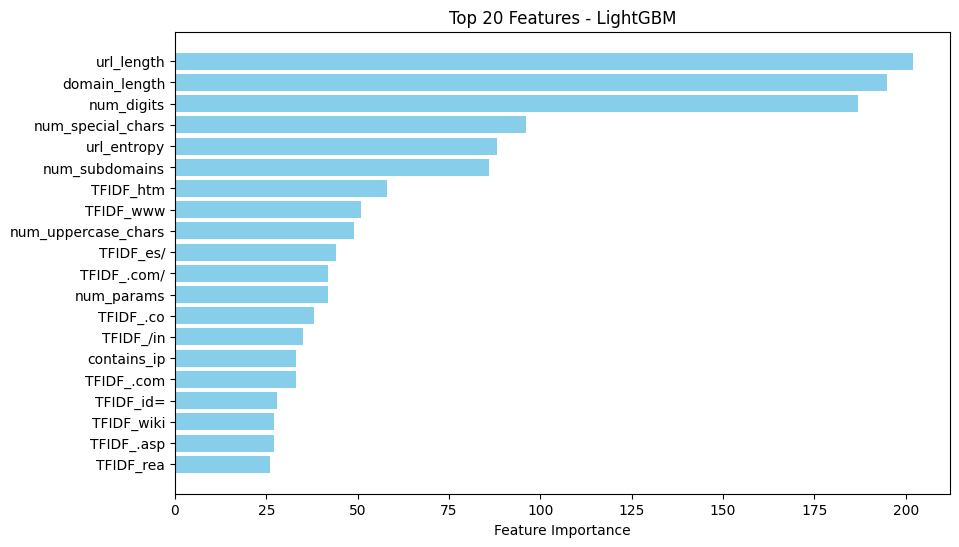

In [14]:
import numpy as np

# Combine manual feature names and TF-IDF feature names
manual_feature_names = list(X_manual.columns)
tfidf_feature_names = [f"TFIDF_{feat}" for feat in tfidf_vectorizer.get_feature_names_out()]
combined_feature_names = manual_feature_names + tfidf_feature_names

def display_top_features(feature_importances, feature_names, top_n=20, model_name="Model"):
    indices = np.argsort(feature_importances)[::-1]
    top_features = [(feature_names[i], feature_importances[i]) for i in indices[:top_n]]
    print(f"\nTop {top_n} Features for {model_name}:\n")
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")
    plt.figure(figsize=(10, 6))
    plt.barh([feature for feature, _ in top_features][::-1],
             [importance for _, importance in top_features][::-1], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Features - {model_name}")
    plt.show()

if "Random Forest" in models:
    rf_importances = models['Random Forest'].feature_importances_
    display_top_features(rf_importances, combined_feature_names, model_name="Random Forest")

if "XGBoost" in models:
    xgb_importances = models['XGBoost'].feature_importances_
    display_top_features(xgb_importances, combined_feature_names, model_name="XGBoost")

if "LightGBM" in models:
    lgb_importances = models['LightGBM'].feature_importances_
    display_top_features(lgb_importances, combined_feature_names, model_name="LightGBM")

### Hyperparameter Tuning for Random Forest

This cell performs hyperparameter tuning for the **Random Forest** model using `GridSearchCV`:

1. **Parameter Grid**  
   - Defines a grid of hyperparameters to test:  
     - `n_estimators`: Number of trees in the forest.  
     - `max_depth`: Maximum depth of each tree.  
     - `min_samples_split`: Minimum samples required to split a node.  
     - `min_samples_leaf`: Minimum samples required at each leaf node.  

2. **Grid Search**  
   - Uses 3-fold cross-validation (`cv=3`) to evaluate combinations of hyperparameters efficiently.  
   - Runs in parallel (`n_jobs=-1`) for faster computation.

3. **Best Model Selection**  
   - Prints the best hyperparameters found.  
   - Fits a new `RandomForestClassifier` with the optimized parameters on the training set.

4. **Model Evaluation**  
   - Predicts on the test set and calculates the accuracy.  
   - Displays a detailed classification report to evaluate performance.

This process identifies the optimal hyperparameters for the Random Forest model and ensures improved performance on the test data.


In [15]:
import numpy as np

def get_top_features(feature_importances, feature_names, top_n=20):
    indices = np.argsort(feature_importances)[::-1]
    top_indices = indices[:top_n]
    top_features = [(feature_names[i], feature_importances[i]) for i in top_indices]
    return top_features, top_indices

# Get top 20 features for Random Forest
if "Random Forest" in models:
    rf_importances = models['Random Forest'].feature_importances_
    top_rf_features, top_rf_indices = get_top_features(rf_importances, combined_feature_names)


# Display top features
print("Top 20 Features for Random Forest:")
for feature, importance in top_rf_features:
    print(f"{feature}: {importance:.4f}")


Top 20 Features for Random Forest:
num_digits: 0.0592
url_entropy: 0.0418
domain_length: 0.0405
url_length: 0.0403
TFIDF_.com/: 0.0287
TFIDF_com/: 0.0286
TFIDF_om/: 0.0268
has_suspicious_words: 0.0240
TFIDF_.php: 0.0226
num_special_chars: 0.0212
TFIDF_.com: 0.0204
TFIDF_.co: 0.0195
TFIDF_com: 0.0177
TFIDF_php: 0.0174
repeated_chars: 0.0158
TFIDF_.ph: 0.0153
TFIDF_ogin: 0.0153
num_uppercase_chars: 0.0129
num_subdomains: 0.0128
TFIDF_gin: 0.0119


In [16]:
from sklearn.model_selection import GridSearchCV

# Get the indices of the top 20 features
top_20_indices = top_rf_indices  # Assuming we are using the top 20 features from Random Forest

# Filter the training and testing datasets to include only the top 20 features
X_train_top20 = X_train[:, top_20_indices]
X_test_top20 = X_test[:, top_20_indices]

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# Perform hyperparameter tuning using GridSearchCV
rf_model = RandomForestClassifier()
grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_top20, y_train)

# Get the best hyperparameters and train the model
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_top20, y_train)
y_pred = best_rf_model.predict(X_test_top20)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy with Best Hyperparameters: {acc:.4f}")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 3.9min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 3.9min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 3.9min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 3.9min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 4.0min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 8.0min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 8.0min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 8.0min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 3.6min
[CV] END max_depth=30, min_samples_